# CCA Anomaly detection on the MM-Fit dataset

This notebook demonstrates use of Canonical Correlation Analysis (CCA) between modalities to detect anomalies.

Results from the MM-Fit dataset are presented, using a pretrained classifier designed for Human Activity Recognition (HAR). The model has a multimodal architecture, with data from each modality feeding into an individual network to learn intra-modality features, before the individual networks are fused to learn cross-modality features. 

We attempt to detect corruption and distribution shift in each modality before the networks are fused, allowing us to remove or reconstruct these modalities before using them for classification. 

CCA learns a linear transformation of two datasets such that the transformed data is maximally correlated. We learn these transformations on clean data, expecting that at test time a pair of clean modalities will have a high correlation, but a corrupt modality will have a low correlation.

Deep Generalised Canonical Correlation Analysis (DGCCA) can be applied to more that two datasets, and can learn nonlinear transformations. Linear Generalised CCA (GCCA) is used to derive a loss function to train a deep network for each modality, transforming the reprentations into a form that GCCA can learn linear transformations of.

We proceed by generating the intermediate representations of the raw MM-Fit data used for anomaly detection, training the deep and linear portions of the DGCCA, and then training anomaly detector thresholds.

In [1]:
import torch
import tqdm
import time
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import RandomSampler

from dgcca.dgcca import DGCCA
from dgcca.anomaly_detection import CcaAnomalyDetector
from mm_fit.utils.dataset import SequentialStridedSampler
from utils.load_datasets import load_data
from utils.load_models import load_models
from utils.noise import GMMNoise

In [2]:
### Config

### notebook settings
learning_rate = 0.001
batch_size = 128
name = 'notebook'      # name used to load/save datasets and training checkpoints
load_features = False  # load modalitiy specific autoenceoder embeddings or generate them
save_features = True  # save generated modality specific embeddings
load_dgcca = False     # load trained dgcca network heads

### mm-fit network parameters
num_epochs = 25
eval_every = 1
early_stop = 200
checkpoint = 200
weights_path = 'output/mmfit_demo_1610541736_checkpoint_0.pth' # path to mm-fit classification network checkpoint
conv_layers = 3
kernel_size = 11
kernel_stride = 2
f_in = 768 # number of input units in the first FC layer
layers = 3 # number of FC layers
hidden_units = 100 # number of hidden units
dropout = 0.0
output = 'output/' # path to output folder

### mm-fit dataset parameters
data_path = "../data" # mm-fit dataset path
workout_ids = ['01', '02', '03', '06', '16'] # workout data to use
dataset_split = {'train_cca': 0.7, 'train_detector': 0.1, 'val': 0.1, 'test': 0.1} # dataset split names and proportions
samplers = [RandomSampler, lambda x: SequentialStridedSampler(x, 1), lambda x: SequentialStridedSampler(x, 1), lambda x: SequentialStridedSampler(x, 1)]
MODALITIES_SUBSET = ['sw_l_acc', 'sw_l_gyr', 'sw_r_acc', 'sw_r_gyr', 'sp_r_acc', 'sp_r_gyr', 'eb_l_acc', 'eb_l_gyr', 'pose_3d'] # modalities to load model and data for
#ALL_MODALITIES = ['sw_l_acc', 'sw_l_gyr', 'sw_l_hr', 'sw_r_acc', 'sw_r_gyr', 'sw_r_hr', 'sp_l_acc', 'sp_l_gyr', 'sp_l_mag', 'sp_r_acc', 'sp_r_gyr', 'sp_r_mag', 'eb_l_acc', 'eb_l_gyr', 'pose_2d', 'pose_3d'] # all modalities available in dataset
num_classes = 11
window_stride = 0.2
window_length = 5
sampling_rate = 50
skeleton_sampling_rate = 30
target_sensor_sampling_rate = 50
grouped = 'GGN'
unseen_test_set = False

# set devices - 'cpu' default, 'cuda:0' if available, sets models as nn.DataParallel if multiple gpus available
parallel = False
workers = 0
if torch.cuda.is_available():
    device = 'cuda:0'
    if torch.cuda.device_count() > 1:
        print('Using {} GPUs'.format(torch.cuda.device_count()))
        parallel = True
    workers = torch.cuda.device_count() * 4 # Set dataloader workers for multipl gpus
else:
    device = 'cpu'

if not os.path.exists(output):
    os.makedirs(output)

We run the raw data through our pretrained autoencoders to obtain the intermediate dataset needed for dgcca training.

In [4]:
dataloaders = load_data(MODALITIES_SUBSET, data_path, ids=workout_ids, splits=[val for val in dataset_split.values()], loader=True, samplers=samplers, batch_size=batch_size, window_stride=window_stride, window_length=window_length, skeleton_sampling_rate=skeleton_sampling_rate, target_sensor_sampling_rate=target_sensor_sampling_rate, workers=workers)

models = load_models(modalities=MODALITIES_SUBSET, device=device, model_wp=weights_path) # load individual modality autoencoders

for model in models.values():
    model.eval()

Dataset splits: [237811, 33973, 33973, 33973]


In [5]:
def get_intermediate_rep(loader, name, models, modalities, noise=None):
    embeddings = {}
    for modality in modalities:
        embeddings[modality] = []

    length = len(loader)
    with tqdm.tqdm(total=length) as pbar:
        for i, (data, labels, reps) in enumerate(loader):
            for modality in modalities:
                input_data = data[modality] if noise is None else noise(data[modality], modality)
                embeddings[modality].append(models[modality](input_data).detach())

            pbar.update(1)
            pbar.set_description('Embedding {} dataset'.format(name))

    for modality, data in embeddings.items():
        cat = torch.cat(data).double()
        embeddings[modality] = cat.reshape((cat.shape[0], -1))
    return embeddings

In [6]:
if load_features:
    with open('output/{}_{}.pkl'.format(name, 'train_cca'), 'rb') as f:
            train_cca = pickle.load(f)
else:
    train_cca = get_intermediate_rep(dataloaders[0], 'train_cca', models, [mod for mod in MODALITIES_SUBSET if mod != 'pose_3d'])
    if save_features:
        with open('output/{}_{}.pkl'.format(name, 'train_cca'), 'wb') as f:
            pickle.dump(train_cca, f, protocol=4)

shapes = {}
for modality in [mod for mod in MODALITIES_SUBSET if mod != 'pose_3d']:
    shapes[modality] = train_cca[modality].shape[1]

Embedding train_cca dataset: 100%|██████████| 1858/1858 [1:55:30<00:00,  3.73s/it]


Define the input, output and hidden layer sizes for the networks in the nonlinear portion of DGCCA, as well as DGCCA parameters.

In [7]:
hidden_layers = [256, 512]
cca_input_dim = 64
cca_lr = 1e-2
cca_epochs = 3
cca_dim = 10
cca_truncparam = 1000
cca_window_size = 128

layer_sizes = [[modality.shape[1]] for modality in train_cca.values()]
for layers in layer_sizes:
    layers.extend(hidden_layers)
    print(layers)

[384, 256, 512]
[384, 256, 512]
[384, 256, 512]
[384, 256, 512]
[384, 256, 512]
[384, 256, 512]
[384, 256, 512]
[384, 256, 512]


Train or load the weights for the nonlinear networks, and train the linear GCCA weights. The linear GCCA requires the embeddings of the training set from the nonlinear networks.

In [8]:
dgcca = DGCCA(layer_sizes, cca_input_dim, device=device)
if load_dgcca:
    dgcca.load_checkpoint('output/{}_dgcca.pth'.format(name))
dgcca.train([output for output in train_cca.values()], cca_epochs, lr=cca_lr, cca_dim=cca_dim, cca_hidden_dim=cca_truncparam, incremental=False)
if not load_dgcca:
    dgcca.save_checkpoint('output/{}_dgcca.pth'.format(name))

Embedding training set:: 100%|██████████| 1858/1858 [01:15<00:00, 24.54it/s]
Decomposed data matrix for view 0
Decomposed data matrix for view 1
Decomposed data matrix for view 2
Decomposed data matrix for view 3
Decomposed data matrix for view 4
Decomposed data matrix for view 5
Decomposed data matrix for view 6
Decomposed data matrix for view 7
Decomposed M_tilde / solved for G
Solved for U in view 0
Solved for U in view 1
Solved for U in view 2
Solved for U in view 3
Solved for U in view 4
Solved for U in view 5
Solved for U in view 6
Solved for U in view 7


The anomaly detector uses the pairwise correlations between each modality to decide which modalities, if any, are corrupt. A second dataset is used to train a threshold correlation for each pair to decide whether a pair contains a corrupted modality or not. The threshold is chosen by comparing the distribution of correlations when both modalities are clean, and when one modality has had noise added.

The clean and corrupt distributions for each pair are shown below, giving an idea of the separability of correlations from each pair. detector.type_1 and detector.type_2 give probabilities of type 1 and 2 errors respectively.

We first generate the intermediate representations of both clean and corrupt data.

In [9]:
gmm_components = 3     # number of gaussian mixture model components for noise generation
snr = 1                # signal to noise ratio
load_detector = False

In [10]:
if load_features:
    with open('output/{}_{}.pkl'.format(name, 'clean'), 'rb') as f:
        clean_data = pickle.load(f)
    with open('output/{}_{}.pkl'.format(name, 'corrupt'), 'rb') as f:
        corrupt_data = pickle.load(f)
else:
    clean_data = get_intermediate_rep(dataloaders[1], 'ad_clean', models, [mod for mod in MODALITIES_SUBSET if mod != 'pose_3d'])

    noise_gen = GMMNoise(data_path, [mod for mod in MODALITIES_SUBSET if mod != 'pose_3d'], workout_ids, gmm_components)
    noise = lambda data, modality: noise_gen.add_noise(data, snr=snr, modality=modality)

    corrupt_data = get_intermediate_rep(dataloaders[1], 'ad_corrupt', models, [mod for mod in MODALITIES_SUBSET if mod != 'pose_3d'], noise=noise)
    if save_features:
        with open('output/{}_{}.pkl'.format(name, 'clean'), 'wb') as f:
            pickle.dump(clean_data, f, protocol=4)
        with open('output/{}_{}_{}.pkl'.format(name, 'corrupt', gmm_components), 'wb') as f:
            pickle.dump(corrupt_data, f, protocol=4)


Embedding ad_clean dataset: 100%|██████████| 266/266 [15:32<00:00,  3.51s/it]
Fitting GMM 2 for eb_l_gyr: 100%|█████████▉| 7.9999999999999964/8 [00:31<00:00,  3.94s/it]
Embedding ad_corrupt dataset: 100%|██████████| 266/266 [14:28<00:00,  3.27s/it]


Getting data embeddings...
Getting noise embeddings...
Computing (6,7) threshold: 100%|██████████| 28/28.0 [01:34<00:00,  3.39s/it]


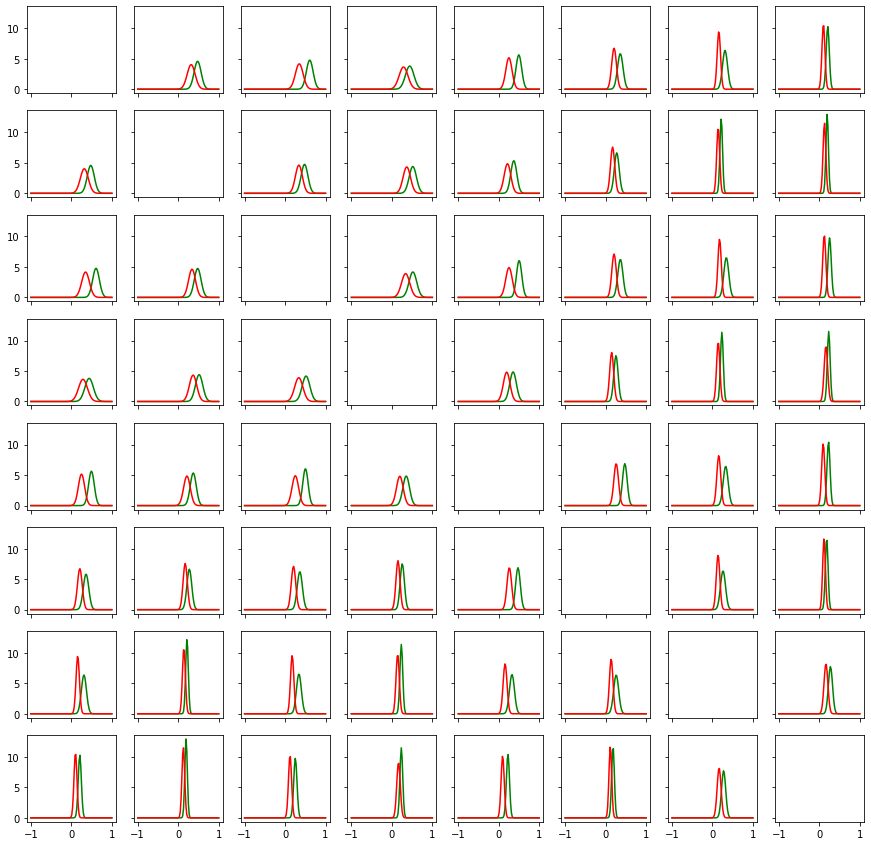

In [11]:
detector = CcaAnomalyDetector(dgcca)

if load_detector:
    detector.thresholds = np.load('output/adthresh.npy')
    detector.classifier = detector.threshold_classifier
else:
    fig = detector.train([mod for mod in clean_data.values()], [mod for mod in corrupt_data.values()], stride='auto', window=cca_window_size, plot=True)

In [12]:
def evaluate_single(detector, data, labels, grace=0):
    pred = detector.detect_anomalies(data, grace=grace)
    tp = ((labels == pred) & (pred == True)).sum()
    tn = ((labels == pred) & (pred == False)).sum()
    fp = ((labels != pred) & (pred == True)).sum()
    fn = ((labels != pred) & (pred == False)).sum()
    return (tp, tn, fp, fn)

def reduce_data(data, modalities):
    reduced = []
    for modality in modalities:
        reduced.append(models[modality](data[modality]).detach().double())
    reduced = [red.reshape((red.shape[0], -1)) for red in reduced]
    return reduced

def noise_like(data):
    mean = data.mean().item()
    std = data.std().item()
    return torch.tensor(np.random.default_rng().normal(mean, std, data.shape))

def acc(results):
    return (results[0] + results[1])/results.sum()

def prec(results):
    return results[0]/(results[0]+results[2])

def rec(results):
    return results[0]/(results[0]+results[3])

def evaluate(detector, loader, noise_gen, n=10, corrupted=1, grace=0):
    results = np.zeros((4))
    with tqdm.tqdm(total=n) as eval_bar:
        for i in range(n):
            data, _, _ = next(iter(loader))
            del data['pose_3d']
            labels = np.array([True]*(len(data)))
            for modality_idx in np.random.default_rng().choice(len(data), size=corrupted, replace=False):
                modality = MODALITIES_SUBSET[modality_idx]
                data[modality] = noise_gen.add_noise(data[modality], modality=modality)
                labels[modality_idx] = False
            data = reduce_data(data, [mod for mod in MODALITIES_SUBSET if mod != 'pose_3d'])
            results += np.array(evaluate_single(detector, data, labels, grace=grace))
            eval_bar.update(1)
            eval_bar.set_description('Sample [{}/{}] | Corrupted: {} | Accuracy: {:.1%} | Precision: {:.1%} | Recall: {:.1%}'.format(i+1, n, corrupted, acc(results), prec(results), rec(results)))
    return results

def test_num_corrupted(detector, loader, noise_gen, test_range, n=100, grace=0):
    results = []
    for corrupted in test_range:
        results.append(evaluate(detector, loader, noise_gen, n, corrupted, grace))
    results = np.stack(results, axis=0)
    all_results = results.sum(axis=0)
    print('\nOverall: | Accuracy: {:.1%} | Precision: {:.1%} | Recall: {:.1%}\nTrue positive: {} | True negative: {} | False positive: {} | False negative: {}'.format(acc(all_results), prec(all_results), rec(all_results), all_results[0], all_results[1], all_results[2], all_results[3]))
    return results

def test_gmm_components(loader, clean_data, test_range, corrupted, snr=1, n=100, grace=0):
    results = []
    for gmm_components in test_range:
        noise_gen = GMMNoise(data_path, [mod for mod in MODALITIES_SUBSET if mod != 'pose_3d'], workout_ids, gmm_components)
        noise = lambda data, modality: noise_gen.add_noise(data, snr=snr, modality=modality)

        corrupt_data = get_intermediate_rep(loader, 'ad_corrupt', models, [mod for mod in MODALITIES_SUBSET if mod != 'pose_3d'], noise=noise)
        detector = CcaAnomalyDetector(dgcca)

        detector.train([mod for mod in clean_data.values()], [mod for mod in corrupt_data.values()], stride='auto', window=cca_window_size)
        results.append(evaluate(detector, loader, noise_gen, n=n, corrupted=corrupted, grace=grace))
    return np.stack(results, axis=0)


Sample [100/100] | Corrupted: 0 | Accuracy: 87.5% | Precision: 100.0% | Recall: 87.5%: 100%|██████████| 100/100 [06:08<00:00,  3.68s/it]
Sample [100/100] | Corrupted: 1 | Accuracy: 88.8% | Precision: 100.0% | Recall: 87.1%: 100%|██████████| 100/100 [07:13<00:00,  4.33s/it]
Sample [100/100] | Corrupted: 2 | Accuracy: 94.6% | Precision: 100.0% | Recall: 92.8%: 100%|██████████| 100/100 [11:44<00:00,  7.04s/it]
Sample [100/100] | Corrupted: 3 | Accuracy: 95.1% | Precision: 100.0% | Recall: 92.2%: 100%|██████████| 100/100 [11:02<00:00,  6.63s/it]
Sample [100/100] | Corrupted: 4 | Accuracy: 98.2% | Precision: 98.5% | Recall: 98.0%: 100%|██████████| 100/100 [05:50<00:00,  3.51s/it]
Overall: | Accuracy: 92.8% | Precision: 99.8% | Recall: 90.7%
True positive: 2720.0 | True negative: 994.0 | False positive: 6.0 | False negative: 280.0



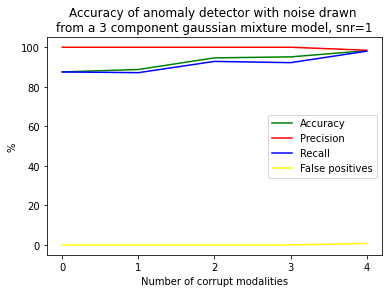

In [13]:
x = range(7)

corruption_results = test_num_corrupted(detector, dataloaders[2], noise_gen, x, grace=2)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_ylabel('%')
ax.set_xticks(x)
ax.set_xlabel('Number of corrupt modalities')
ax.set_title('Accuracy of anomaly detector with noise drawn \nfrom a 3 component gaussian mixture model, snr=1')

plt.plot(x, [100*acc(result) for result in corruption_results], label='Accuracy', c='green')
plt.plot(x, [100*prec(result) for result in corruption_results], label='Precision', c='red')
plt.plot(x, [100*rec(result) for result in corruption_results], label='Recall', c='blue')
plt.plot(x, [100*result[2]/sum(result) for result in corruption_results], label='False positives', c='yellow')
ax.legend()

Fitting GMM 2 for eb_l_gyr: 100%|█████████▉| 7.9999999999999964/8 [00:05<00:00,  1.58it/s]
Embedding ad_corrupt dataset: 100%|██████████| 266/266 [38:08<00:00,  8.60s/it]
Getting data embeddings...
Getting noise embeddings...
Computing (6,7) threshold: 100%|██████████| 28/28.0 [07:12<00:00, 15.44s/it]
Sample [100/100] | Corrupted: 3 | Accuracy: 71.4% | Precision: 68.6% | Recall: 100.0%: 100%|██████████| 100/100 [13:15<00:00,  7.96s/it]
Fitting GMM 2 for eb_l_gyr: 100%|█████████▉| 7.9999999999999964/8 [01:59<00:00, 14.90s/it]
Embedding ad_corrupt dataset: 100%|██████████| 266/266 [34:14<00:00,  7.72s/it]
Getting data embeddings...
Getting noise embeddings...
Computing (6,7) threshold: 100%|██████████| 28/28.0 [01:28<00:00,  3.16s/it]
Sample [100/100] | Corrupted: 3 | Accuracy: 74.6% | Precision: 71.2% | Recall: 99.8%: 100%|██████████| 100/100 [04:20<00:00,  2.60s/it]
Fitting GMM 2 for eb_l_gyr: 100%|█████████▉| 7.9999999999999964/8 [00:56<00:00,  7.06s/it]
Embedding ad_corrupt dataset: 

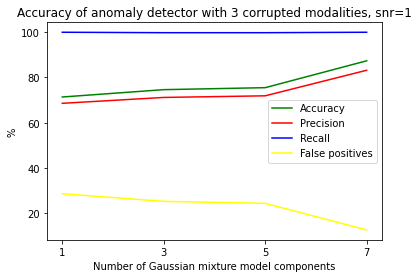

In [14]:
x = range(1,9,2)

gmm_results = test_gmm_components(dataloaders[2], clean_data, x, corrupted=3, snr=1, n=100, grace=2)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_ylabel('%')
ax.set_xticks(x)
ax.set_xlabel('Number of Gaussian mixture model components')
ax.set_title('Accuracy of anomaly detector with 3 corrupted modalities, snr=1')

plt.plot(x, [100*acc(result) for result in gmm_results], label='Accuracy', c='green')
plt.plot(x, [100*prec(result) for result in gmm_results], label='Precision', c='red')
plt.plot(x, [100*rec(result) for result in gmm_results], label='Recall', c='blue')
plt.plot(x, [100*result[2]/sum(result) for result in gmm_results], label='False positives', c='yellow')
ax.legend()